
# <span style="color: red"> **Classification my_MNIST by RESNET18**</span> 


<img src="arh_resnet18.png" width="900" height="220">


### <span style="color: red"> **Data propagation**</span> 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as tfs
import torchvision.datasets as dst
from torch.utils.data import TensorDataset, DataLoader, random_split
import os
import mlflow
import matplotlib.pyplot as plt


In [2]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((224, 224)),
    tfs.Grayscale()
])
train_data = dst.ImageFolder(r'C:\Users\Admin\My_project_1\my_MNIST\Train_data', transform = data_tfs)
test_data =  dst.ImageFolder(r'C:\Users\Admin\My_project_1\my_MNIST\Test_data', transform = data_tfs)

In [3]:
print(train_data.classes)
print(train_data.class_to_idx)

print(test_data.classes)
print(test_data.class_to_idx)

print(f'Длина тренировочных данных: {len(train_data)}')
print(f'Длина тестовых данных: {len(test_data)}')

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
{'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4, 'class_5': 5, 'class_6': 6, 'class_7': 7, 'class_8': 8, 'class_9': 9}
['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
{'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4, 'class_5': 5, 'class_6': 6, 'class_7': 7, 'class_8': 8, 'class_9': 9}
Длина тренировочных данных: 3000
Длина тестовых данных: 1000


In [3]:
# train_data, val_data = random_split(train_data, [0.8,0.2])    
train_data, test_data = random_split(train_data, [0.8,0.2])

In [4]:
print(f'Длина тренировочного датасета:{len(train_data)}')
# print(f'Длина валидационного датасета:{len(val_data)}')
print(f'Длина тестового датасета:{len(test_data)}')

Длина тренировочного датасета:3000
Длина тестового датасета:1000


In [5]:
# создание DATALoader
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
# val_loader = DataLoader(val_data, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 16, shuffle = False)

In [15]:
img, label = train_loader.dataset[10]
print(img.size())
print(label)
print(train_loader.dataset[10])


torch.Size([1, 224, 224])
6
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 6)


### <span style="color: red"> **Model ResNet18**</span> 

In [6]:
#building residual block (num = 8)
class Residual_block (nn.Module):
    def __init__(self, in_block, out_block, stride=1):
         super(Residual_block, self).__init__()
         self.conv1 = nn.Conv2d(in_block, out_block, kernel_size=3, stride=stride, padding=1, bias=False)
         self.bn1 = nn.BatchNorm2d(out_block)
         self.relu = nn.ReLU(inplace=True)
         self.conv2 = nn.Conv2d(out_block, out_block, kernel_size=3, stride=1, padding=1, bias=False)
         self.bn2 = nn.BatchNorm2d(out_block)

         self.skip_connect = nn.Sequential()
         if stride != 1 or in_block != out_block:
              self.skip_connect = nn.Sequential(
                nn.Conv2d(in_block, out_block, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_block)
            )
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip_connect(x)
        out = self.relu(out)
        return out
          
        

In [ ]:
#building ResNet 18  (it is all architecture) 
class ResNet18 (nn.Module):
    def __init__(self, Residual_block, num_classes=10):
         super(ResNet18, self).__init__()
         self.in_block = 64                                               # 1 input image channel, 64 output channels, 7x7 square conv kernel
         self.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias=False) #  на выходе получаем 64 шт. 112*112

         self.bn1 = nn.BatchNorm2d(64)
         self.relu = nn.ReLU(inplace=True)
         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  #  на выходе получаем 64 шт. 55*55
         
         self.layer1 = self.make_layer(Residual_block, 64, 2, stride=1)    #  создание 4 остаточных групп (2 - количество блоков в группе)
         self.layer2 = self.make_layer(Residual_block, 128, 2, stride=2)
         self.layer3 = self.make_layer(Residual_block, 256, 2, stride=2)
         self.layer4 = self.make_layer(Residual_block, 512, 2, stride=2)
        
         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))      #  выход (1,1)
         self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_block, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_block, out_block, stride))
            self.in_block = out_block
        return nn.Sequential(*layers)                             # выводит не список, а значения элементов списка
  
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)             # расчет функции потерь; view(-1) преобразует torch.Size([128, 1])  в torch.Size([128])
        out = self.fc(out)
        # print (out.shape)
        # exit
        return out
    

In [8]:
def ResNet():
    return ResNet18(Residual_block)

### <span style="color: red"> **Обучение модели в VS**</span> 

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_losses = []
test_losses = []

#define ResNet18
net = ResNet().to(device)

#set hyperparameter
EPOCH = 2
LR = 0.001

#define loss funtion & optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR)                      # momentum=0.9, weight_decay=5e-4


cpu


In [11]:
for epoch in range(EPOCH):
   
    print('\nEpoch_train: %d' % (epoch + 1))
   
    net.train()
    train_loss = 0.0
    test_loss = 0.0
    max_train_acc = 0
    max_test_acc = 0
    correct = 0.0
    correct1 = 0.0
    train_samples = 0
    
    for i, data in enumerate(train_loader, 0):
        if i == 5:
            break
        #prepare dataset
        length = len(train_loader)
        inputs, labels = data 
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = loss_func(outputs, labels)          
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        train_loss += loss.item() * outputs.size(0)                  # train_loss+= mean_batch_loss * batch_size 
                                                                   # Умножение на outputs.size(0) (батч) это по сути преобразование среднего значения ЛОСС за батч в
                                                                   #  суммарное, поскольку для подсчета Лосс за прогон суммарное за батч делиться на общее количество
                                                                   # фоток в прогоне, а не на количество итераций.
        train_samples += outputs.size(0)                           #подсчитвыет количество фото
        _, predicted = torch.max(outputs.data, 1)                  # _, predicted - значение тензора, номер индекса с этим максимальным значением
                                                                    # .data связывает между собой два тензора
        correct += predicted.eq(labels.data).cpu().sum()          # суммирует количество совпадающих 1 с labels
        acc_train = 100*correct / train_samples                    # точность 100. * correct / train_samples  
              
                      
        
        if acc_train > max_train_acc:
            max_train_acc = acc_train
            min_train_loss = train_loss / train_samples
                              
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.2f%% ' 
              % (epoch + 1, (i + 1 ), train_loss / train_samples, acc_train))                
        
    train_losses.append(train_loss / train_samples)
    

    print('\nEpoch_test: %d' % (epoch + 1))    
    
    with torch.no_grad():
        correct = 0
        test_samples = 0
        for i, data in enumerate(test_loader):          
            if i == 5:
                break
            net.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_loss += loss.item() * outputs.size(0)
            test_samples += outputs.size(0)
            correct += (predicted == labels).sum()
            acc_test = 100*correct / train_samples    
            
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.2f%% ' 
              % (epoch + 1, (i + 1 + epoch * length), test_loss / test_samples,  acc_test))        
    
            if acc_test > max_test_acc:
                max_test_acc = acc_test
                min_test_loss = test_loss / test_samples
                torch.save(net, f'model_my_resnet18.pth')            # сохраняет модель с лучшими показателями
    
        
    test_losses.append(test_loss / test_samples)
        
    print('------------')
    print('MAX_train_acc: %.2f%% ' % (max_train_acc))      
    print('MAX_test_acc: %.2f%% ' % (max_test_acc))
    print('MIN_train_loss: %.3f ' % (min_train_loss))      
    print('MIN_test_loss: %.3f ' % (min_test_loss))   
  
        
        


Epoch_train: 1
[epoch:1, iter:1] Loss: 2.364 | Acc: 25.00% 
[epoch:1, iter:2] Loss: 2.385 | Acc: 12.50% 
[epoch:1, iter:3] Loss: 2.391 | Acc: 10.42% 
[epoch:1, iter:4] Loss: 2.385 | Acc: 10.94% 
[epoch:1, iter:5] Loss: 2.381 | Acc: 10.00% 

Epoch_test: 1
[epoch:1, iter:1] Loss: 2.274 | Acc: 0.00% 
[epoch:1, iter:2] Loss: 2.274 | Acc: 0.00% 
[epoch:1, iter:3] Loss: 2.274 | Acc: 0.00% 
[epoch:1, iter:4] Loss: 2.274 | Acc: 0.00% 
[epoch:1, iter:5] Loss: 2.274 | Acc: 0.00% 
------------
MAX_train_acc: 25.00% 
MAX_test_acc: 0.00% 
MIN_train_loss: 2.364 


NameError: name 'min_test_loss' is not defined

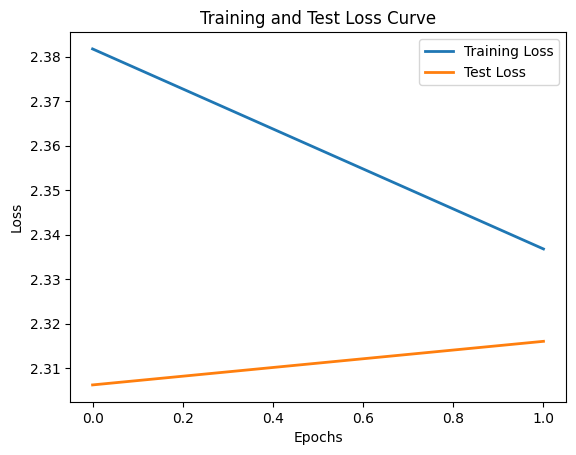

In [11]:

plt.plot(train_losses, label="Training Loss",linewidth=2)
plt.plot(test_losses, label="Test Loss",linewidth=2)
plt.title('Training and Test Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
maxacc = 0
N_epochs = 5

for epoch in range(N_epochs):
    epoch += 1
    net.train()
    train_loss = 0.0
    train_acc = 0.0
    train_samples = 0

    for itr, data in enumerate(train_loader):
        if itr == 5:
            break
        imgs = data[0].to(device)  # [B, H, W]
        labels = data[1].to(device)

        y_pred = net(imgs)  
        loss = criterion(y_pred, labels)

        train_loss += loss.item() * imgs.size(0)
        train_acc += accuracy(y_pred, labels) * imgs.size(0)
        train_samples += imgs.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= train_samples
    train_acc /= train_samples
    print(f'The {epoch} Epoch of network learning is over:')
    print(f'Train results Epoch {epoch}: Train loss - {train_loss:.4f}, Train accuracy - {train_acc:.4f}')

    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_samples = 0

    with torch.no_grad():
        for itr, data in enumerate(test_loader):
            if itr == 5:
                break
            imgs = data[0].to(device)
            labels = data[1].to(device)
            y_pred = net(imgs)
            loss = criterion(y_pred, labels)

            val_loss += loss.item() * imgs.size(0)
            val_acc += accuracy(y_pred, labels) * imgs.size(0)
            val_samples += imgs.size(0)

    val_loss /= val_samples
    val_acc /=val_samples
    print(f'Validation results Epoch {epoch}: Val loss - {val_loss:.4f}, Val accuracy - {val_acc:.4f}')

    if val_acc > maxacc:
        print('Saving model because its better')
        maxacc = val_acc
        # torch.save(model, f'mymodel_fc.pth')
    print('---')

The 1 Epoch of network learning is over:
Train results Epoch 1: Train loss - 1.9490, Train accuracy - 0.4625
Validation results Epoch 1: Val loss - 2.0483, Val accuracy - 0.1875
Saving model because its better
---
The 2 Epoch of network learning is over:
Train results Epoch 2: Train loss - 1.9895, Train accuracy - 0.3000
Validation results Epoch 2: Val loss - 2.0377, Val accuracy - 0.3000
Saving model because its better
---


KeyboardInterrupt: 